In [6]:
import pandas as pd
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import scipy
import seaborn

import re

#Data handling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#Normalizer
from sklearn.preprocessing import MinMaxScaler

from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

x_train = []
y_train = []
x_test = []
y_test = []

In [7]:
def get_gender(text):
    text = text[len(text)-4]
    if('F' in text):
        return 'F'
    elif('M' in text):
        return 'M'
    else:
        return 'N/A'
    
def get_word_segments(align_file):
    segments = []
    with open(align_file,'r') as openFile:
        read_lines = openFile.readlines()
        lines = read_lines[1:len(read_lines)-1]
        for line in lines:
            splitted = line.split()
            segments.append({'sf': splitted[0], 'ef':splitted[1],'seg_scr':splitted[2],'word':splitted[3]})
    return segments
    
def generate_IEMOCAP_df():
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    alignment = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_alignments_path = temp_root + forced_alignment
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    for line in openFile.readlines():
                        if(line.startswith('[')):
                            line = line.split()
                            key = line[3]
                            emotion = line[4]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        for conversation in conversations:
            files_path = temp_conversations_path+ conversation
            alignments_path = temp_alignments_path + conversation
            files = os.listdir(files_path)
            for file in files:
                key,suf = file.split('.')
                if(suf == 'wav'):
                    data[key].append(files_path + '/'+ file)
                    data[key].append(alignments_path + '/'+key+'.wdseg')
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path','alignment_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    full = full.reset_index()
    full['gender'] = full['index'].apply(get_gender)
    return full

# Models

In [8]:
def log_reg(x_train,y_train,x_test,y_test, delete = True):
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    Y_pred = logreg.predict(x_test)
    acc_log = round(logreg.score(x_test, y_test) * 100, 2)
    if(delete):
        del logreg
        return Y_pred, acc_log
    return logreg,Y_pred,acc_log

# _, acc_log = log_reg(x_train,ang_train, x_test, ang_test)
# print(acc_log)

def svc(x_train,y_train,x_test,y_test, delete = True):
    svc = SVC()
    svc.fit(x_train,y_train)
    Y_svcpred = svc.predict(x_test)
    acc_svc = round(svc.score(x_test, y_test) * 100,2)
    if(delete):
        del svc 
        return Y_svcpred, acc_svc
    return svc, Y_svcpred, acc_svc

# _, acc_svc = svc(x_train,ang_train,x_test,ang_test)
# print(acc_svc)

def knn(x_train,y_train,x_test,y_test,n_neighbors = 3,delete = True):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_train, y_train)
    Y_knnpred = knn.predict(x_test)
    acc_knn = round(knn.score(x_test, y_test) * 100, 2)
    if(delete):
        del knn
        return Y_knnpred, acc_knn
    return knn, Y_knnpred, acc_knn    
# _,acc_knn = knn(x_train,ang_train,x_test,ang_test)
# print(acc_knn)

def gaussian(x_train,y_train,x_test,y_test,delete = True):
    gaussian = GaussianNB()
    gaussian.fit(x_train, y_train)
    Y_gaussianpred = gaussian.predict(x_test)
    acc_gaussian = round(gaussian.score(x_test, y_test) * 100, 2)
    if(delete):
        del gaussian
        return Y_gaussianpred, acc_gaussian
    return gaussian, Y_gaussianpred, acc_gaussian

# _, acc_gaussian = gaussian(x_train,ang_train,x_test,ang_test)
# print(acc_gaussian)

def perceptron(x_train,y_train,x_test,y_test,delete = True):
    perceptron = Perceptron()
    perceptron.fit(x_train, y_train)
    Y_perceptronpred = perceptron.predict(x_test)
    acc_perceptron = round(perceptron.score(x_test, y_test) * 100, 2)
    if(delete):
        del perceptron
        return Y_perceptronpred, acc_perceptron
    return perceptron, Y_perceptronpred ,acc_perceptron
# _, acc_perceptron = perceptron(x_train,ang_train,x_test,ang_test)
# print(acc_perceptron)

def linear_svc(x_train,y_train,x_test,y_test,delete = True):
    linear_svc = LinearSVC()
    linear_svc.fit(x_train, y_train)
    Y_linearsvcpred = linear_svc.predict(x_test)
    acc_linear_svc = round(linear_svc.score(x_test, y_test) * 100, 2)
    if(delete):
        del linear_svc
        return Y_linearsvcpred, acc_linear_svc
    return linear_svc, Y_linearsvcpred, acc_linear_svc
# _, acc_linear_svc = linear_svc(x_train,ang_train,x_test,ang_test)
# print(acc_linear_svc)

def sgd(x_train,y_train,x_test,y_test,delete = True):
    sgd = SGDClassifier()
    sgd.fit(x_train, y_train)
    Y_linearsgdpred = sgd.predict(x_test)
    acc_sgd = round(sgd.score(x_test, y_test) * 100, 2)
    if(delete):
        del sgd
        return Y_linearsgdpred , acc_sgd
    return sgd, Y_linearsgdpred, acc_sgd
# _, acc_sgd = sgd(x_train,ang_train,x_test,ang_test)
# print(acc_sgd)

def decision_tree(x_train,y_train,x_test,y_test,delete = True):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)
    Y_dectreepred = decision_tree.predict(x_test)
    acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
    if(delete):
        del decision_tree
        return Y_dectreepred , acc_decision_tree
    return decision_tree, Y_dectreepred , acc_decision_tree
# _, acc_decision_tree = decision_tree(x_train,ang_train,x_test,ang_test)
# print(acc_decision_tree)

def random_forest(x_train,y_train,x_test,y_test,n_estimators = 100, delete = True):
    random_forest = RandomForestClassifier(n_estimators= n_estimators)
    random_forest.fit(x_train, y_train)
    Y_pred = random_forest.predict(x_test)
    acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
    if(delete):
        del random_forest
        return Y_pred, acc_random_forest
    return random_forest, Y_pred, acc_random_forest
# _, acc_random_forest = random_forest(x_train,ang_train, x_test , ang_test)
# print(acc_random_forest)

def compare_models(x_train, y_train, x_test, y_test):
    _,acc_svc = svc(x_train,y_train,x_test,y_test)
    _,acc_knn = knn(x_train,y_train,x_test,y_test)
    _,acc_log = log_reg(x_train,y_train,x_test,y_test)
    _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
    _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
    _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
    _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
    _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
    _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
    models = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree'],
        'Score': [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]})
    return models #.sort_values(by='Score', ascending=False)

def compare_models_x_emotions(x_train, x_test, emotions):
    result = {'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree']}
    for emotion,data in emotions.iteritems():
        y_train = data[0]
        y_test = data[1]
        _,acc_svc = svc(x_train,y_train,x_test,y_test)
        _,acc_knn = knn(x_train,y_train,x_test,y_test)
        _,acc_log = log_reg(x_train,y_train,x_test,y_test)
        _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
        _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
        _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
        _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
        _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
        _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
        result[emotion] = [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]
    models = pd.DataFrame(result)
    models = models[['Model'] + list(emotions.iterkeys())]
    return models
        
    



In [9]:
# full = generate_IEMOCAP_df()
data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
data.head(3)


index  start_time  end_time                 text  \
0  Ses01F_impro01_F000      6.2901    8.2357           Excuse me.   
1  Ses01F_impro01_F001     10.0100   11.3925                Yeah.   
2  Ses01F_impro01_F002     14.8872   18.0175  Is there a problem?   

                                            wav_path  \
0  data/IEMOCAP_full_release/Session1/sentences/w...   
1  data/IEMOCAP_full_release/Session1/sentences/w...   
2  data/IEMOCAP_full_release/Session1/sentences/w...   

                                      alignment_path emotion  valence  \
0  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   
1  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   
2  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   

   arousal  dominance gender  
0      2.5        2.5      F  
1      2.5        2.5      F  
2      2.5        2.5      F

In [10]:
# full.to_csv('data/IEMOCAP_sentences.csv')

data = data[(data.emotion != 'oth')&(data.emotion != 'xxx')]
data.groupby('emotion').count()

index  start_time  end_time  text  wav_path  alignment_path  valence  \
emotion                                                                         
ang       1103        1103      1103  1103      1103            1103     1103   
dis          2           2         2     2         2               2        2   
exc       1041        1041      1041  1041      1041            1041     1041   
fea         40          40        40    40        40              40       40   
fru       1849        1849      1849  1849      1849            1849     1849   
hap        595         595       595   595       595             595      595   
neu       1708        1708      1708  1708      1708            1708     1708   
sad       1084        1084      1084  1084      1084            1084     1084   
sur        107         107       107   107       107             107      107   

         arousal  dominance  gender  
emotion                              
ang         1103       1103    1103  
dis            2          2       2  
exc         1041       1041    1041  
fea           40         40      40  
fru         1849       1849    1849  
hap          595        595     595  
neu         1708       1708    1708  
sad         1084       1084    1084  
sur          107        107     107

In [11]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data['emotion'] = data['emotion'].map( emotional_mapping ).astype(int)

In [12]:
#Exclude ['oth', 'xxx', 'dis', 'sur','fea']
data = data[data.emotion < 6]
y = data.emotion
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
# print X_train.shape, y_train.shape
# print X_test.shape, y_test.shape

# try:
#     with open('pickles/base_datasets.pickle','wb') as f:
#         save = {
#             'X_train' : X_train,
#             'X_test' : X_test,
#             'y_train': y_train,
#             'y_test' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to base datasets pickle: ', e)
try:
    with open('pickles/base_datasets.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

(5904, 11) (5904,)
(1476, 11) (1476,)


In [13]:
test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav'
def get_mfcc_feature(filename,n_mfcc):
    y, sr = librosa.load(filename)
    #IPython.display.Audio(data=y,rate=sr)
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)
    print("Finished "+ filename)
    return np.mean(mfcc.T,axis=0)

def map_for_emotion(y_list, emotional_mapping,emotion):
    return list(map(lambda x: 1 if x == emotional_mapping[emotion] else 0,y_list))


# MFCC (20) Features - Mel-frequency cepstral coefficients

In [133]:
# x_train = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))
# x_test = list(map(lambda x: get_mfcc_feature(x,20),X_test['wav_path']))
# try:
#     with open('pickles/mfcc20.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to mfcc pickle: ', e)

try:
    with open('pickles/mfcc20.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

In [134]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [135]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [136]:
models_result = compare_models_x_emotions(x_train, x_test, emotions)

In [137]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    75.27       86.31    85.70        75.27   
1                         KNN    74.80       83.06    84.62        69.31   
2         Logistic Regression    76.22       86.65    87.47        74.66   
3               Random Forest    76.90       86.59    87.94        75.47   
4                 Naive Bayes    63.89       77.71    79.13        69.99   
5                  Perceptron    74.93       13.69    85.70        71.07   
6  Stochastic Gradient Decent    75.27       86.25    60.98        36.72   
7                  Linear SVC    75.27       14.02    86.18        75.27   
8               Decision Tree    68.63       79.40    81.71        64.91   

   Anger  Happiness  
0  85.37      92.07  
1  85.98      90.72  
2  88.01      92.14  
3  87.67      92.01  
4  80.49      92.07  
5  85.43      92.07  
6  86.31      89.97  
7  87.67      92.07  
8  78.79      85.50

## Scaled MFCC (20) Features

In [ ]:
def scale_features(x_train, x_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_x_train = scaler.fit_transform(x_train)
#     print(scaled_x_train.min(axis=0))
#     print(scaled_x_train.max(axis=0))
    scaled_x_test = scaler.fit_transform(x_test)
    return scaled_x_train,scaled_x_test

scaled_x_train, scaled_x_test = scale_features(x_train,x_test)

In [ ]:
models_result = compare_models_x_emotions(scaled_x_train, scaled_x_test, emotions)

In [ ]:
models_result

### Invidual Emotion Models

In [ ]:
# compare_models(x_train,ang_train, x_test , ang_test)
# compare_models(x_train,sad_train, x_test , sad_test)
# compare_models(x_train,exc_train, x_test , exc_test)
# compare_models(x_train,neu_train, x_test , neu_test)
# compare_models(x_train,fru_train, x_test , fru_test)
# compare_models(x_train,hap_train, x_test , hap_test)

# RMSE

In [138]:
def get_rmse(filename):
    y, sr = librosa.load(filename)
    rmse = librosa.feature.rmse(y)
    print("Finished "+ filename)
    return rmse[0]

test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav'
rmse = get_rmse(test_file)
rmse.shape

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav


(126,)

In [139]:
# x_train = list(map(lambda x: get_rmse(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_rmse(x),X_test['wav_path']))
# try:
#     with open('pickles/rmse.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to rmse pickle: ', e)
try:
    with open('pickles/rmse.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [140]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

((5904, 1375), (1476, 1471))
((5904, 1471), (1476, 1471))


In [141]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

# Zero Crossing Rate

In [ ]:
def get_zcr(filename):
    y,sr = librosa.load(filename)
    zcr = librosa.feature.zero_crossing_rate(y  + 0.0100) # 0.0200 background noise reduction
    return zcr[0] 
    
test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F000.wav'
y,sr = librosa.load(test_file)
zcr = get_zcr(test_file)
zcr.shape


In [ ]:
# x_train = list(map(lambda x: get_zcr(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_zcr(x),X_test['wav_path']))
# try:
#     with open('pickles/zcr.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to zcr pickle: ', e)
try:
    with open('pickles/zcr.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

#  Fourier Transform -- Too big, not useful

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
--- 0.383305072784 seconds ---
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav


5904

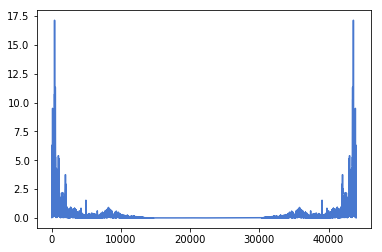

In [15]:
def get_fft(filename):
    y,sr = librosa.load(filename)
    fft = scipy.fft(y)
    print("Finished "+filename)
    return np.absolute(fft)
    
import time
start_time = time.time()
fft = get_fft(test_file)
print("--- %s seconds ---" % (time.time() - start_time))
test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
fft = get_fft(test_file)
plt.plot(fft)
fft.shape

In [131]:
# x_train = list(map(lambda x: get_fft(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_fft(x),X_test['wav_path']))
# try:
#     with open('pickles/fft.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to fft pickle: ', e)
# try:
#     with open('pickles/fft.pickle','rb') as f:
#         save = pickle.load(f)
#         x_train = save['train_dataset']
#         y_train = save['train_labels']
#         x_test = save['test_dataset']
#         y_test = save['test_labels']
#         del save
# except Exception as e:
#     print('Error at:', e)


In [ ]:
# ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
# ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
# sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
# sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
# exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
# exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
# neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
# neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
# # fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
# fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
# hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
# hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
# x_train = pd.DataFrame(x_train).fillna(0)
# x_test = pd.DataFrame(x_test).fillna(0)
# print(x_train.shape, x_test.shape)
# if(x_train.shape[1] > x_test.shape[1]):
#     diff = x_train.shape[1] - x_test.shape[1]
#     for i in range(diff):
#         x_test[x_test.shape[1] + i] = 0
# else:
#     diff = x_test.shape[1] - x_train.shape[1]
#     for i in range(diff):
#         x_train[x_train.shape[1] + i] = 0
# print(x_train.shape, x_test.shape)

In [ ]:
# emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
# models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
# models_result

# Spectrogram

In [44]:
def get_spectrogram(filename,n_fft = 2048):
    y,sr = librosa.load(filename)
    Y = librosa.stft(y, n_fft=n_fft)
    Ymag = librosa.amplitude_to_db(np.absolute(Y))
    print('Finished '+ filename)
    return np.mean(Ymag.T,axis=0)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
stft = get_spectrogram(test_file)
stft2 = get_spectrogram(test_file2)
print(stft.shape,stft2.shape)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((1025,), (1025,))


In [45]:
# x_train = list(map(lambda x: get_spectrogram(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_spectrogram(x),X_test['wav_path']))
# try:
#     with open('pickles/spectrogram.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to spectrogram pickle: ', e)
try:
    with open('pickles/spectrogram.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav
Fi

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M019.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M030.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F005.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F008.wav
Fi

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M007.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M021.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M030.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F022.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M040.wav
Fi

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M053.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M013.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M066.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F024.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_sc

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M014.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F042.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M043.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M047.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F024.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M053.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F052.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M027.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F020.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F013.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F032.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F030.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M027.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F036.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M028.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M058.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M002.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M068.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M045.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M043.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F047.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M070.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M040.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F013.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M065.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F016.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F030.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F022.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_sc

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_sc

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F017.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M000.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M028.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M010.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F000.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F001.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M017.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F047.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M023.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F016.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M027.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F014.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F023.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F078.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F011.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F006.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M002.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F025.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M047.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M008.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F007.wav
Fi

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F006.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F032.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M056.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M020.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M029.wav
Finish

In [46]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [47]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

((5904, 1025), (1476, 1025))
((5904, 1025), (1476, 1025))


In [48]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [49]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [50]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.46       85.98    87.06        72.22   
1                         KNN    76.42       83.27    85.23        67.82   
2         Logistic Regression    78.52       84.82    87.60        71.41   
3               Random Forest    80.08       86.31    89.63        72.02   
4                 Naive Bayes    51.90       58.60    71.34        51.36   
5                  Perceptron    78.32       68.97    43.29        72.22   
6  Stochastic Gradient Decent    78.32       85.91    86.59        35.84   
7                  Linear SVC    79.47       86.31    88.89        72.02   
8               Decision Tree    71.61       79.67    84.55        65.04   

   Anger  Happiness  
0  84.62      92.28  
1  84.28      91.19  
2  83.40      88.89  
3  86.72      92.28  
4  71.00      48.98  
5  85.91      92.28  
6  85.03      89.02  
7  86.79      10.84  
8  80.56      83.54

# Mel-spectrogram

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((128,), (128,))


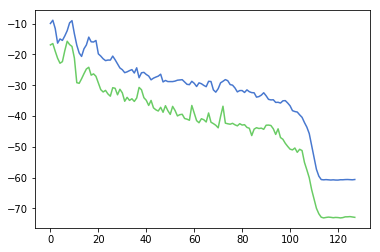

In [70]:
def get_melspectrogram(filename,n_fft = 4096):
    y,sr = librosa.load(filename)
    Y = librosa.feature.melspectrogram(y, n_fft=n_fft)
    Ymag = librosa.power_to_db(Y)
    print('Finished '+ filename)
    return np.mean(Ymag,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
stft = get_melspectrogram(test_file)
stft2 = get_melspectrogram(test_file2)
print(stft.shape,stft2.shape)
plt.plot(stft2)
plt.plot(stft)

In [71]:
# x_train = list(map(lambda x: get_melspectrogram(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_melspectrogram(x),X_test['wav_path']))
# try:
#     with open('pickles/melspectrogram.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to melspectrogram pickle: ', e)
try:
    with open('pickles/melspectrogram.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F032.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F005.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M005.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M015.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M040.wav
Fi

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F013.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M053.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M044.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M066.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M027.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_sc

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M027.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F008.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M029.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M036.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M047.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M053.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F019.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M030.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F005.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M025.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F009.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F012.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M011.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F04

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M006.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M005.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M021.wav
Fi

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F029.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M044.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F037.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F009.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M049.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M037.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F065.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M025.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F051.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M019.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M057.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M005.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_imp

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F020.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M003.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M007.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F052.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M002.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F034.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F011.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F010.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F059.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F008.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M007.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_sc

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M005.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M027.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F048.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M072.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M007.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F042.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M011.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F006.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M034.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F006.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F050.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M015.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M003.wav
Fi

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F006.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M014.wav
Finish

In [72]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [73]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [74]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [75]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.39       85.98    87.26        72.22   
1                         KNN    76.63       83.47    86.52        69.04   
2         Logistic Regression    79.00       86.31    89.50        72.49   
3               Random Forest    80.22       86.25    88.82        71.82   
4                 Naive Bayes    49.86       59.89    70.66        51.76   
5                  Perceptron    78.32       85.84    87.87        71.68   
6  Stochastic Gradient Decent    74.12       68.36    85.23        67.62   
7                  Linear SVC    79.40       85.98    88.89        72.29   
8               Decision Tree    72.02       79.13    83.81        65.58   

   Anger  Happiness  
0  84.62      92.28  
1  85.23      90.99  
2  86.04      92.07  
3  86.04      92.28  
4  70.39      72.29  
5  86.11      92.28  
6  85.16      92.07  
7  85.37      92.28  
8  79.74      84.08

# constant-Q spectrogram

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((84,), (84,))


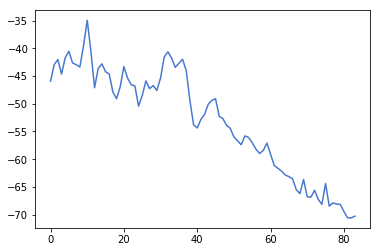

In [94]:
def get_cqt(filename,n_fft = 4096):
    y,sr = librosa.load(filename)
    C = librosa.cqt(y,sr=sr)
    Clog = librosa.amplitude_to_db(np.abs(C))
    print('Finished '+ filename)
    return np.mean(Clog,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
cqt = get_cqt(test_file)
cqt2 = get_cqt(test_file2)
print(cqt.shape,cqt2.shape)
plt.plot(cqt)

In [95]:
# x_train = list(map(lambda x: get_cqt(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_cqt(x),X_test['wav_path']))
# try:
#     with open('pickles/cqt.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to cqt pickle: ', e)
try:
    with open('pickles/cqt.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav
Fi

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F007.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F066.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F044.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M028.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F004.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F057.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M002.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M045.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F001.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M022.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M029.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F023.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F018.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F008.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M023.wav
Finished

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M035.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M049.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F035.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M043.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F008.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F049.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F014.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M028.

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M005.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M015.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M025.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M009.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M023.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F019.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M003.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M073.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F007.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F011.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M016.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F048.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M072.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M040.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F042.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F001.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F019.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F018.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M005.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M004.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M001.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M012.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M026.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F002.

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_scri

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M049.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M049.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M036.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M00

In [97]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [98]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [99]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [100]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.25       85.98    87.94        72.22   
1                         KNN    77.71       84.15    87.87        68.09   
2         Logistic Regression    78.79       86.45    88.89        71.68   
3               Random Forest    80.69       85.91    89.23        72.29   
4                 Naive Bayes    48.64       61.59    68.29        52.64   
5                  Perceptron    78.32       37.13    61.04        71.88   
6  Stochastic Gradient Decent    28.46       85.91    87.06        72.22   
7                  Linear SVC    78.25       14.02    86.52        72.22   
8               Decision Tree    71.48       79.00    84.28        64.84   

   Anger  Happiness  
0  84.62      92.28  
1  84.21      91.67  
2  86.18      92.21  
3  86.52      92.28  
4  68.70      81.98  
5  85.91      92.28  
6  85.43      92.28  
7  86.52      92.28  
8  79.13      83.60

# Chroma

In [132]:
def get_chroma_stft(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_stft(y,sr=sr)
    print('Finished '+ filename)
    return np.mean(chromagram,axis=1)

def get_chroma_cqt(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_cqt(y,sr=sr)
    print('Finished ' + filename)
    return np.mean(chromagram,axis=1)

def get_chroma_cens(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_cens(y,sr=sr)
    print('Finished ' + filename)
    return np.mean(chromagram,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
chroma_stft = get_chroma_stft(test_file)
chroma2_stft = get_chroma_stft(test_file2)
chroma_cqt = get_chroma_cqt(test_file)
chroma2_cqt = get_chroma_cqt(test_file2)
chroma_cens = get_chroma_cens(test_file)
chroma2_cens = get_chroma_cens(test_file2)
print(chroma_stft.shape,chroma2_stft.shape)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((12,), (12,))


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


In [127]:
# x_train = list(map(lambda x: get_chroma_stft(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_stft(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_stft.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma stft pickle: ', e)
try:
    with open('pickles/chroma_stft.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F006.

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F032.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F005.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M001.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F013.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F012.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M022.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M016.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M016.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F066.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M03

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F015.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M007.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script0

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F025.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F015.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F014.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav
Finished

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F010.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M033.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M013.wav
Fi

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M048.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M044.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M007.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M006.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M023.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M049.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M037.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F065.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M025.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F051.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F021.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M057.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F015.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_sc

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F038.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M010.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F052.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M010.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F004.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_imp

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M028.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F059.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F022.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M012.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M027.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M021.wav
Fi

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M001.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F040.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F012.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M003.wav
Finished

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M023.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F017.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F003.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M035.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F009.

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M040.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F050.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M015.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M003.wav
Fi

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F006.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M044.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F007.wav
Finish

In [128]:
# x_train = list(map(lambda x: get_chroma_cqt(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_cqt(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_cqt.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma cqt pickle: ', e)
try:
    with open('pickles/chroma_cqt.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M014.wav
Finished

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F018.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F009.wav
Finished

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F002.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F023.wav
Finisheddata

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F027.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M007.wav
Finished

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F017.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F028.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M012.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M053.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M044.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M066.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F024.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F032.wav
Fi

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M038.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M020.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F021.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M017.wav
Finished

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F035.wav
Fi

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M053.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F052.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F007.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F013.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F021.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M002.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M020.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M036.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F019.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F006.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M027.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F003.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M005.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F004.wa

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M037.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F027.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F012.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M039.wav
Finished

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M058.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F019.wa

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M048.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F008.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M001.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F047.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M070.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M042.wav
Fi

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F000.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M065.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M007.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M035.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M011.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F023.wav
Fi

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F014.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M010.wav
Finisheddata/IEMOCAP_full_releas

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M001.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F020.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F026.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F035.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F047.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M023.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M019.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F021.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F025.

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F078.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M029.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M052.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M024.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M011.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M004.wav
Fini

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M002.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M059.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M037.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M020.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M030.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F016.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F035.

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F028.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M046.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F014.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav
Finishedda

In [129]:
# x_train = list(map(lambda x: get_chroma_cens(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_cens(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_cens.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma cens pickle: ', e)
try:
    with open('pickles/chroma_cens.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M052.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M045.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F063.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M082.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M045.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F047.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F050.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F059.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F054.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M053.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M076.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M060.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F061.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M080.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M063.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M053.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M055.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M066.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M045.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M052.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F058.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F056.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M045.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M047.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M038.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F066.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M053.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F052.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M002.wav

/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)



Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F045.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F079.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F058.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F057.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M057.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F060.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M067.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M045.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M053.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F045.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F053.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F062.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M064.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F055.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M052.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F051.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M061.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M061.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F047.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M058.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M068.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M051.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M048.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M045.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F053.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M066.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M070.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M045.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M054.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M049.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M065.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F065.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M050.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F051.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M057.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F052.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M043.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F049.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F052.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M079.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M071.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M050.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F070.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M073.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F059.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F050.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F047.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F060.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F064.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F045.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F048.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M072.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F035.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M064.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F078.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M048.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M051.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M062.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M052.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F037.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F045.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M036.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M020.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M058.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M059.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F074.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F050.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F045.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M042.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F046.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F048.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M056.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M040.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F045.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F039.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M024.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M047.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M051.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F017.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M033.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F037.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M067.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M012.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M034.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F008.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F015.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F018.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F040.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M049.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M049.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M032.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M023.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F027.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M026.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M042.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M016.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M010.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F028.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M031.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F020.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F003.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F006.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F001.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M021.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F035.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F041.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M044.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M004.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F000.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M014.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F025.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F009.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F002.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M022.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F013.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F038.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M019.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F011.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M029.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F030.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F007.wav


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


In [130]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

In [ ]:
onset_frames = librosa.onset.onset_detect(y, sr=sr)
print onset_frames

In [ ]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print onset_times

In [ ]:
onset_samples = librosa.frames_to_samples(onset_frames)
print onset_samples

In [ ]:
clicks = librosa.clicks(times=onset_times,length=len(y))

In [ ]:
ipd.Audio(y, rate=sr)

In [ ]:
frame_sz = int(0.200*sr)
segments = np.array([y[i:i+frame_sz] for i in onset_samples])

In [ ]:
def concatenate_segments(segments, sr=22050, pad_time = 0.300):
    padded_segments = [np.concatenate([segment,np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [ ]:
concatenated_signal = concatenate_segments(segments,sr)

In [ ]:
ipd.Audio(concatenated_signal, rate=sr)

In [ ]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print zcrs

In [ ]:
sum(librosa.core.zero_crossings(y))

In [ ]:
# get_word_segments(test_align)

In [ ]:
ind = np.argsort(zcrs)
print(ind)

In [ ]:
concatenated_signal = concatenate_segments(segments[ind],sr)

In [ ]:
ipd.Audio(concatenated_signal,rate=sr)

In [ ]:
rmse = [sum(librosa.feature.rmse(segment)) for segment in segments]